In [103]:
from module import decomposition
from module import dickey_fuller
from module import arima_endog
from module import arima_exog
from module import rmse_cv
from module import lasso_reg


import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import hstack
import warnings
import os
from fredapi import Fred
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# NEED TO CHANGE EXOGENOUS VARIABLES PER LASSO REGRESSION

### Set Datetime

In [104]:
start = datetime(2000,2,1)
end = datetime(2020,1,31)

## Gather Endogenous Data 

In [105]:
FR = web.DataReader('FR', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
FR = FR.copy()
FR.index = pd.to_datetime(FR.index)
FR = FR.resample('MS').mean()
FR['mid'] = (FR['high']+FR['low'])/2
FR.drop(labels = ['high', 'low', 'open', 'close', 'volume'], axis = 1, inplace = True)

In [106]:
FR

,mid
2000-02-01,26.318214
2000-03-01,26.892826
2000-04-01,27.723158
2000-05-01,29.697273
2000-06-01,30.174318
...,...
2019-09-01,39.227875
2019-10-01,40.290109
2019-11-01,41.975713
2019-12-01,41.489007


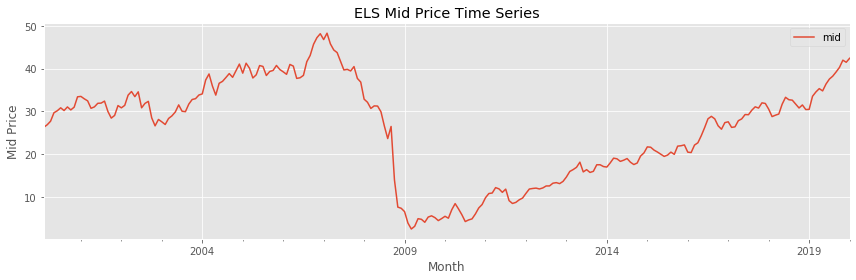

In [107]:
plt.style.use('ggplot')
FR.plot(figsize = (12,4))
plt.xlabel('Month')
plt.ylabel('Mid Price')
plt.title('ELS Mid Price Time Series')
plt.tight_layout()
plt.show();

## Perform Decomposition of Time Series

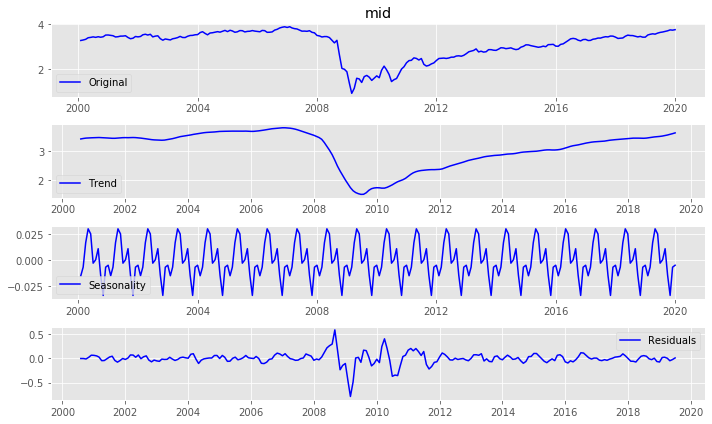

In [108]:
decomposition(FR)

In [109]:
FR_diff = FR.diff(periods = 1).dropna()

In [110]:
dickey_fuller(FR_diff)

The series passes the Dickey Fuller Test for Stationarity. P-Value = 0.006170886001187084


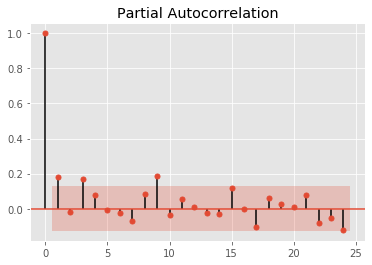

In [111]:
plot_pacf(FR_diff);

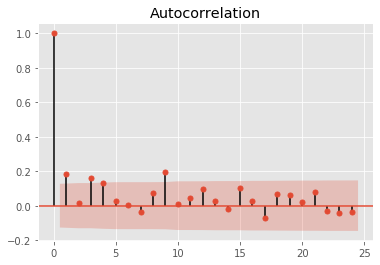

In [112]:
plot_acf(FR_diff);

In [113]:
parameters = (0,1,5)
seasonal_parameters = (0,1,5,12)

## Train Test Split

In [114]:
FR_train = FR[:'2017']
FR_test = FR['2018':]

## SARIMAX Model (No Exogenous Variables)

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  215
Model:             SARIMAX(0, 1, 5)x(0, 1, 5, 12)   Log Likelihood                -268.161
Date:                            Tue, 11 Feb 2020   AIC                            560.322
Time:                                    15:38:25   BIC                            595.274
Sample:                                02-01-2000   HQIC                           574.526
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0005      0.001      0.792      0.428      -0.001       0.002
ma.L1          0.1706     

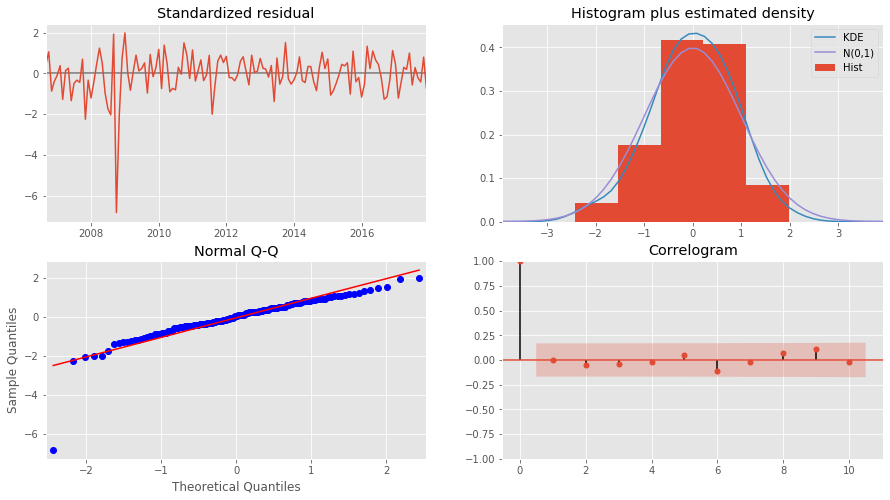

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Predictions vs. Observed: 
 


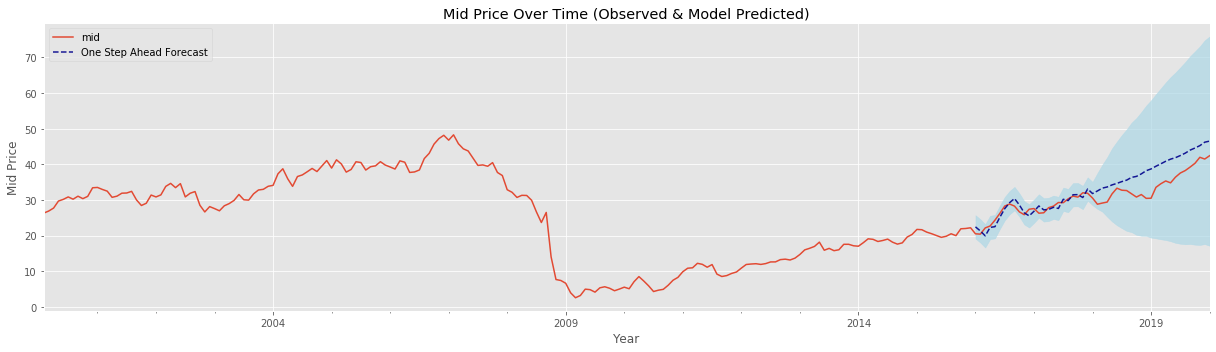

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Future Forecast: 
 


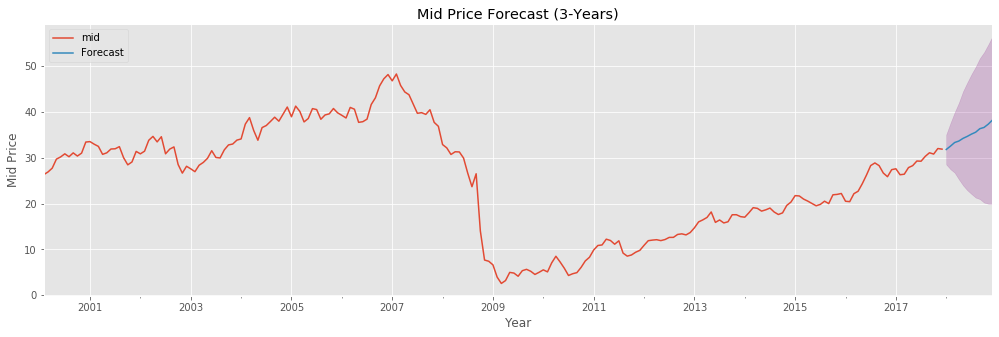

In [116]:
arima_endog(FR_train, FR, parameters, seasonal_parameters)

## Gather Exogenous Variables

In [79]:
FR_rates = pd.read_csv('data/FR_rates.csv', index_col = 'date')

### Train Test Split Exogenous Variables

### Perform Lasso Regression

The R-score of the Lasso Regression is: 0.9878729586083098

usd1mtd156n       -3.197451
mortgage30us      -1.248196
mortgage15us      -2.976175
dcpf3m             4.080561
cpn3m             -0.192908
dcpf1m            -0.888217
aaa               -0.698094
baa               -1.452166
dff                4.316908
flexsc            -0.429874
t10y2y            -0.000000
t10y3m             2.986316
tedrate           -2.349787
t10yff             0.504435
t5yff             -1.699348
tb6smffm           5.316759
usd3mtd156n        1.378603
usd12md156n        0.968437
eur1wkd156n        1.049401
mprime            -0.948908
tb3ms              0.000000
dtb6               0.596743
dgs10              0.549402
dgs3mo            -1.052516
dexuseu            5.408603
dexchus            3.530692
dexusuk           13.180269
dexsius           21.710629
nasdaqcom         -0.005058
willreitind        0.003777
willlrgcap         0.000445
willsmlcap         0.000195
vxdcls            -0.221862
stlfsi          

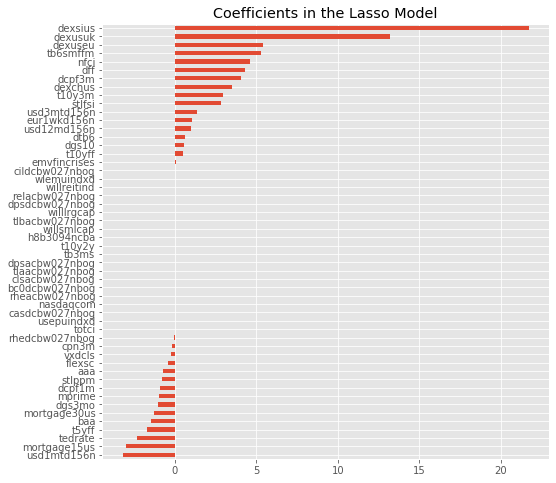

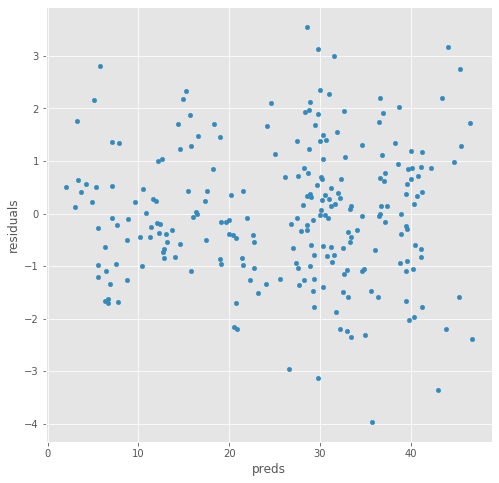

In [80]:
lasso_reg(FR_rates)

### Select significant exogenous features from Lasso Regression

In [81]:
FR_rates_train = FR_rates[:'2018']
FR_rates_test = FR_rates['2018':]

In [82]:
exog_train = FR_rates_train[['nasdaqcom', 'willreitind', 'willlrgcap', 'willsmlcap', 'vxdcls', 'h8b3094ncba', 'bc0dcbw027nbog', 'casdcbw027nbog', 'cildcbw027nbog',
                              'dpsdcbw027nbog', 'clsacbw027nbog', 'dpsacbw027nbog', 'relacbw027nbog', 'rheacbw027nbog', 'tlaacbw027nbog', 'tlbacbw027nbog', 'totci',
                              'usepuindxd', 'wlemuindxd']]

In [83]:
exog_test = FR_rates_test[['nasdaqcom', 'willreitind', 'willlrgcap', 'willsmlcap', 'vxdcls', 'h8b3094ncba', 'bc0dcbw027nbog', 'casdcbw027nbog', 'cildcbw027nbog',
                              'dpsdcbw027nbog', 'clsacbw027nbog', 'dpsacbw027nbog', 'relacbw027nbog', 'rheacbw027nbog', 'tlaacbw027nbog', 'tlbacbw027nbog', 'totci',
                              'usepuindxd', 'wlemuindxd']]

In [84]:
exog_train.shape, exog_test.shape

((215, 19), (25, 19))

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  215
Model:             SARIMAX(0, 1, 5)x(0, 1, 5, 12)   Log Likelihood                -218.256
Date:                            Tue, 11 Feb 2020   AIC                            498.512
Time:                                    14:18:43   BIC                            588.804
Sample:                                02-01-2000   HQIC                           535.204
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
drift           1.733e-05      0.001      0.014      0.989      -0.002       0.002
nasdaqcom     

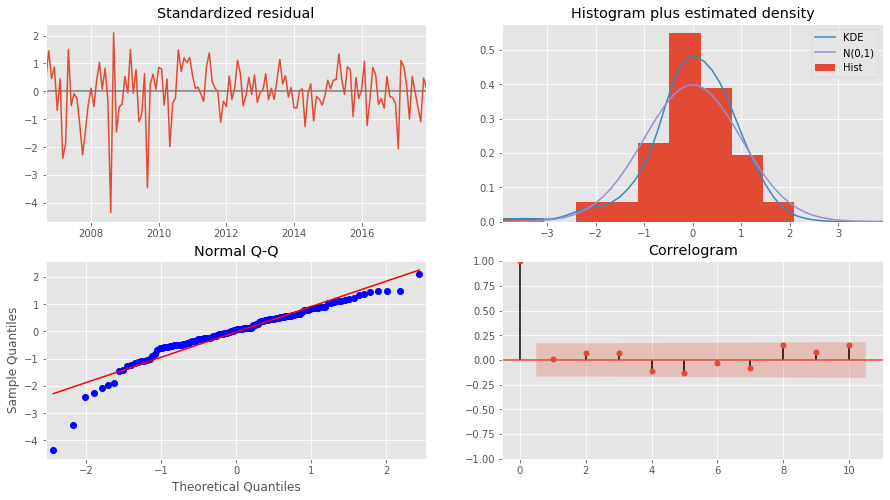

In [85]:
arima_model = sm.tsa.statespace.SARIMAX(FR_train,
                                        exog = exog_train,
                                        order = (0,1,5),
                                        seasonal_order = (0,1,5,12),
                                        enforce_stationarity = False,
                                        enforce_invertability = False,
                                        trend = 't')
results = arima_model.fit()
print(f'Summary: {results.summary()}')
print()
print('Diagnostics: ')
results.plot_diagnostics(figsize = (15,8))
plt.show()

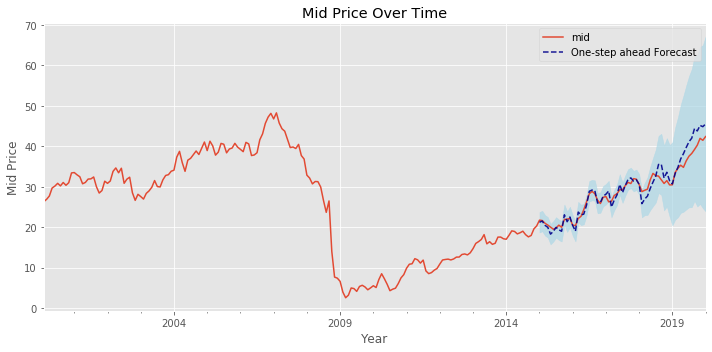

In [86]:
predictions = results.get_prediction(start = pd.to_datetime('2015-01-01'), end = pd.to_datetime('2020-01-01'), dynamic=False, exog = exog_test)
pred_conf = predictions.conf_int()
    
#Plot observed values
ax = FR['2000-02-01':].plot(label='observed', figsize = (10,5))

#Plot predicted values
predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, color = 'darkblue', style = '--')

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='lightblue', alpha=.7)

#Set axes labels
ax.set_xlabel('Year')
ax.set_ylabel('Mid Price')
plt.legend(loc = 'best')
plt.title(f'Mid Price Over Time')
plt.tight_layout()
plt.show()
    

In [59]:
FR

,mid
2000-02-01,26.318214
2000-03-01,26.892826
2000-04-01,27.723158
2000-05-01,29.697273
2000-06-01,30.174318
...,...
2019-09-01,39.227875
2019-10-01,40.290109
2019-11-01,41.975713
2019-12-01,41.489007


In [91]:
from dateutil.relativedelta import relativedelta
start_forecast = datetime.strptime('2020-02-01', "%Y-%m-%d")
date_list = [start_forecast + relativedelta(months = x) for x in range(0,12)]
future = pd.DataFrame(index = date_list, columns = FR_rates.columns)
FR_rates_new = pd.concat([FR_rates, future])

In [95]:
FR_rates_new.drop(labels = 'mid', axis = 1, inplace = True)

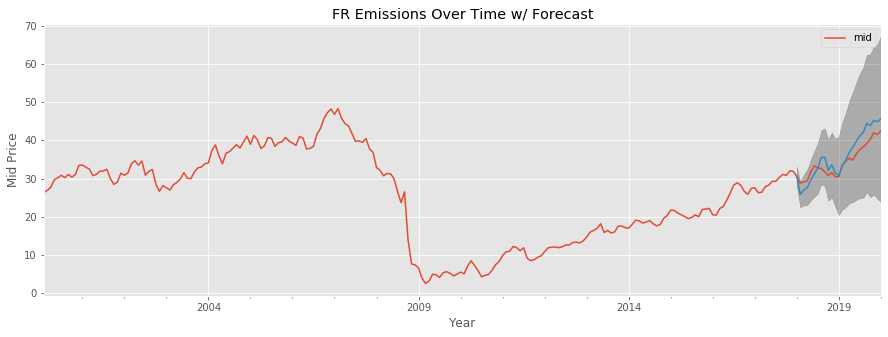

In [99]:
forecast = results.get_forecast(steps = 25, dynamic = False, exog = exog_test)
pred_conf = forecast.conf_int()

ax = FR.plot(label = 'observed', figsize = (15,5))
forecast.predicted_mean.plot(ax=ax, label = 'forecast')
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:,0], 
                pred_conf.iloc[:,1], 
                color = 'k', alpha = .25)

ax.set_xlabel('Year')
ax.set_ylabel('Mid Price')
ax.set_title('FR Emissions Over Time w/ Forecast')
plt.show()